In [1]:
import pImpactR as impact
import matplotlib.pyplot as plt
import numpy as np

In [2]:
beam,lattice = impact.readInputFile('test_halo.in')
beam.nCore_y = 2
beam.nCore_z = 2
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
lattice = impact.clearLattice(lattice)

reading ImpactZ input file (test_halo.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


# pData at 100turn

In [3]:
pData = impact.readParticleData(1008,ke,mass,freq,1)  # pId=1008 is at 100 turn

In [4]:
npt =len(pData)
pData.shape

(999996, 9)

In [5]:
pData[:,-1] = np.arange(npt) + 1

In [6]:
q_m = pData[0,6]
q_m

1.065788973815158e-09

In [7]:
pData[:,7]

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
pData[:,7] = 1  # relative charge weight

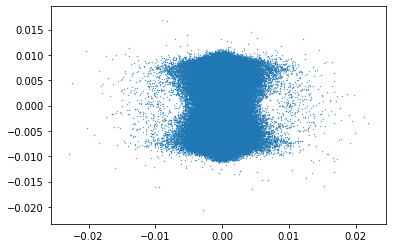

In [9]:
plt.scatter(pData[:,0],pData[:,2],s=0.1)

# add test particles

In [10]:
testP = 0.0
k=1
pTest = []
for x in np.linspace(-0.012,0.012,128):
    for y in np.linspace(0,0.013,64):
        pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k+npt])
        k=k+1
pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)

nptTest= 8192


In [11]:
new_pData = np.concatenate((pData,pTest),axis=0)

In [12]:
new_pData.shape

(1008188, 9)

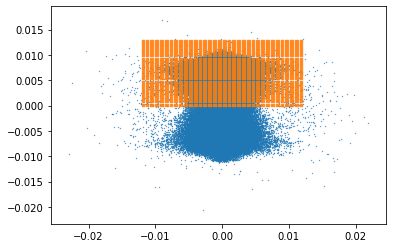

In [13]:
plt.scatter(new_pData[:npt,0],new_pData[:npt,2],s=0.1)
plt.scatter(new_pData[npt:,0],new_pData[npt:,2],s=0.2)

In [14]:
impact.writeParticleData(new_pData,ke,mass,freq)

In [15]:
# write = impact.getElem('write_raw_ptcl')
# write.file_id = 7000
# write.format_id = 2
# write.turn = 1
# impact.writeInputFile(beam,[impact.getElem('loop'),write])
# impact.run(beam,order=1)

# new lattice starting from midpoint of NL

In [16]:
for i,elem in enumerate(lattice):
    if 'nonlinear' in elem.type:
        print(elem)
        break


             length: 0.9 [m]
           n_sckick: 5 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
       tune_advance: 0.3
       total_length: 1.8
     start_position: 0.0
        pipe_radius: 10.0 [m]
               type: 'nonlinear_insert_sliced'


In [17]:
newLattice = lattice[i+1:] + lattice[:i+1]

In [18]:
L=0
for elem in newLattice:
    if 'length' in elem:
        L=L+elem.length
print(L)

39.96822971580007


In [19]:
loop = impact.getElem('loop')
loop.turns = 100
newLattice.insert(0,loop)

In [20]:
TBT = impact.getElem('TBT')
TBT.pID_begin = npt +1
TBT.pID_end   = npt +nptTest
TBT.file_id   = 100
newLattice.insert(1,TBT)

In [21]:
write = impact.getElem('write_raw_ptcl')
write.file_id = 7100
write.format_id = 2
write.turn = 100
newLattice.append(write)

In [22]:
beam.n_particles = npt +nptTest
impact.writeInputFile(beam,newLattice,'test_TBT_from0_to100.in')

In [23]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 7100

write.file_id = 7200
TBT.file_id = 200

impact.writeInputFile(beam,newLattice,'test_TBT_from100_to200.in')

In [24]:
newLattice = impact.getInverseLattice(newLattice)
newLattice.insert(0,loop)
newLattice.append(TBT)

In [25]:
TBT.file_id = 7100

impact.writeInputFile(beam,newLattice,'test_TBT_from100_to0.in')

In [26]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 7200

loop.turns = 200
TBT.file_id = 7200

impact.writeInputFile(beam,newLattice,'test_TBT_from200_to0.in')